# Music Genre Classification
## Introduction
---

In [1]:
#Imports
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#install librosa 
#Librosa is a python package for music and audio analysis.
#pip install librosa
import librosa
import librosa.display

from IPython.display import Image

## Table of Contents
---

* #### [Problem Statement](#p)
* #### [Data](#d)
* #### [Background Research](#b)
* #### [Feature Overview](#f)
* #### [Sources](#s)

## Problem Statement<a id='p'></a>
---

Music streaming services are quite ubiquitous in our society.

> * Global music subscribers surged 26.4% to 523.9 million during the Covid pandemic.
> * Music streaming makes up 84% of the U.S. music industry revenue.
> * 82.1 million Americans are paid subscribers to on-demand music streaming. <sup>1</sup>


The enormous demand for music streaming services presents a number of problems for companies that hosts large amounts of music. Each of these companies not only offers a large amount of music, they also gain new audio daily at an alarming rate. In 2022, Apple Music boasted 100 million songs in its library.<sup>2</sup> Luminate posits that 120,000 new songs are added to streaming platforms daily.<sup>3</sup> Streaming platforms need ways to accurately classify audio before assimilation into their libraries. This ensures the music is appropriately categorized for further use in effective segmentation efforts, personalized playlists, recommendations, and marketing. 

This project aims to develop music classification models with the utilization of the audio collected for the GTZAN study.<sup>4</sup> The audio collection consists of 1000, 30 second music samples from 10 different genres. As part of this study, participants classified music by genre with an accuracy of 70%. The goal of this project is to build a model that exceeds this accuracy level. A variety of classification models are tested such as Logistic Regression, Ridge Classifier, XGBClassifier, Linear Discriminant Analysis, and Linear Support Vectors. The developed models can become tools used by streaming companies to further create effective, personalized music experiences for their consumers.  

## Data<a id='d'></a>
---

This audio collection was curated by George Tzanetakis and Perry Cook for use in their 2002 study, "Musical genre classification of audio signals".

> #### Genres
Genres are "labels created and used by humans for categorizing and describing the vast universe of music. Musical genres have no strict definitions and boundaries as they arise through a complex interaction between the public, marketing, historical, and cultural factors."<sup>4</sup>

> #### Dataset
"To ensure variety of different recording qualities the excerpts were taken from radio, compact disks, and
MP3 compressed audio files. The files were stored as 22 050 Hz, 16-bit, mono audio files. An effort was made to ensure that
the training sets are representative of the corresponding musical genres. The Genres dataset has the following classes: classical, country, disco, hiphop, jazz, rock, blues, reggae, pop, metal."<sup>4</sup>

> #### Human Study
"Using a ten-way forced-choice paradigm college students were able to accurately judge (53% correct) after listening to only 250-ms samples and (70% correct)after listening to 3 s (chance would be 10%). Listening to more than 3 s did not improve their performance. The subjects where trained using representative samples from each genre. The ten genres used in this study were: blues, country, classical, dance, jazz, latin, pop, R&B, rap, and rock."<sup>4</sup>

## Background Research<a id='b'></a>
---

### Sound Waves

Sound waves are a type of energy that’s released when an object vibrates. These acoustic waves travel from their source through air or another medium. Our brains translate the pressure waves into understandable words, music, or signals.

A sound's speed refers to how fast the waves move from peak to trough and back to peak. The technical term is frequency. It is measured in hertz (Hz), which represents cycles-per-second. Faster frequencies correspond to higher-pitched sounds. 

Amplitude equates to a sound’s volume or intensity. Amplitude is measured in decibels (dB), a logarithmic scale.

Timbre is determined by the unique harmonics formed by the combination of notes in a chord. "The way these sound together helps keep a piano from sounding like a guitar, or an angry grizzly bear from sounding like a rumbling tractor engine.<sup>5</sup>

### Analog-Digital Conversion

Analog sound is a continuous signal with infinite amplitude values at any one point in time. Digital audio is a representation of sound converted into a digital signal. During the analog to digital conversion process, amplitudes of an analog sound wave are captured at a specified sample rate and bit depth and converted into data. The higher the sample rate and bit depth, the higher the audio resolution.<sup>6</sup>

## Feature Overview<a id='f'></a>
---

### Audio Import

* Download audio collection zip file from:
> https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection

* Unzip folder and place in project directory.

* Folder name should be "genres" with 10 genre folders containing 100 files each

In [2]:
#blues.00000.au audio file used for all following demonstrations
audio_path = f'../genres/blues/blues.00000.au'

#signal (blues) is audio time series as numpy array with length of (sample rate * time) 
#sample rate (sr) of audio = 22.05 kHz
blues,sr = librosa.load(audio_path)

In [3]:
#audio time series
blues

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32)

In [4]:
#number of samples
total_samples = blues.size
total_samples

661794

In [5]:
#duration of 1 sample
sample_duration = 1 / sr
print(f"Sample length is {sample_duration:3f} seconds.")

Sample length is 0.000045 seconds.


In [19]:
# duration of audio in seconds
duration = sample_duration * total_samples
print(f"The audio lasts for {round(duration)} seconds.")

The audio lasts for 30 seconds.


**Below are numerous examples of features used in this project's classification modeling. These features were chosen through research and use of [`librosa documentation`](https://librosa.org/doc/latest/index.html).**

## Time Domain Features
---

### Tempo

In music, tempo refers to the speed at which a piece of music is played. It is measured in beats per minute (BPM), which indicates the number of beats that occur within a minute. A higher BPM means the music is played at a faster pace, while a lower BPM indicates a slower pace. <sup>7</sup>

### Amplitude Envelope

The Amplitude Envelope aims to extract the maximum amplitude within each frame and string them all together. The signal is split into its constituent windows and the maximum amplitude within each window is found. Then, the maximum amplitude in each window along time is plotted.<sup>8</sup> This provides a rough estimation of loudness. <sup>9</sup>

In [4]:
#Amplitude Envelope Formula Source 
'''
https://github.com/musikalkemist/AudioSignalProcessingForML/blob/master/
8-%20Implementing%20the%20amplitude%20envelope/Implementing%20the%
20amplitude%20envelope.ipynb
'''

def ae(signal):
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), 512): 
        amplitude_envelope_current_frame = max(signal[i:i+1024]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)    

#### Root Mean Squared Energy

RMS is a metering tool that measures the average loudness of an audio track within a window of roughly 300 milliseconds. The value displayed is an average of the audio signal. The RMS value provides a more accurate look at the perceived loudness of the music track for the average listener.<sup>10</sup>

To calculate:<sup>11</sup>
* Square the amplitudes within each window and sum them 
* Divide by the frame length
* Take the square root

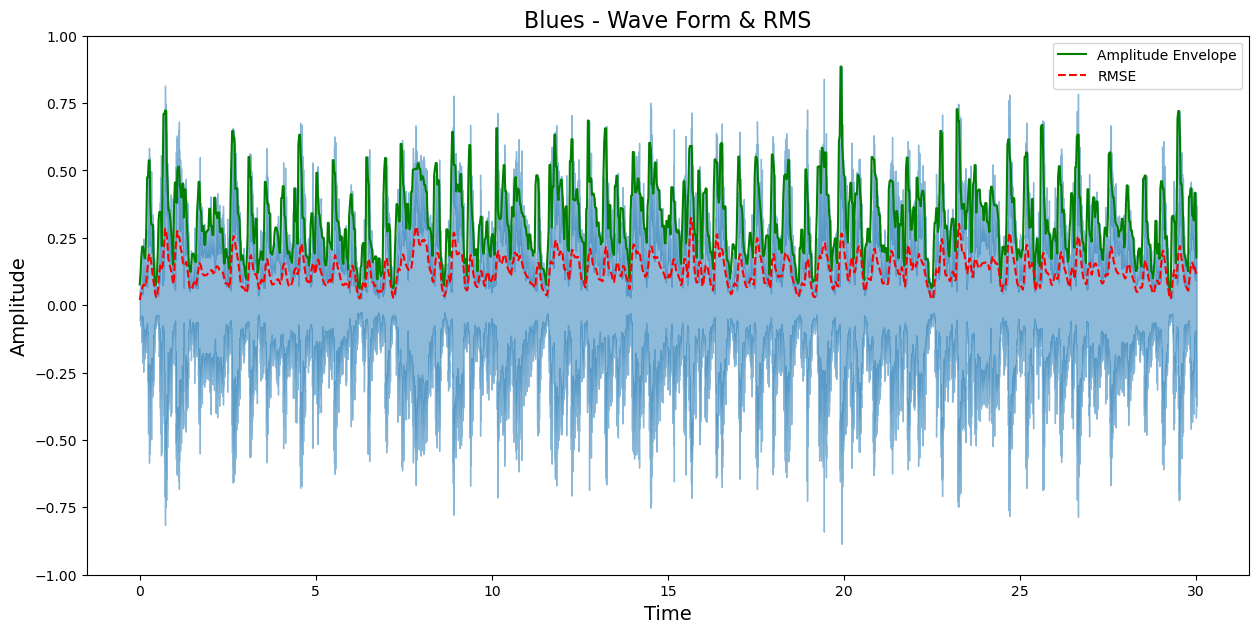

In [30]:
#rms for each frame
rms = librosa.feature.rms(y=blues)
rms = rms[0]

#convert frames to time
frames = range(len(rms))
t = librosa.frames_to_time(frames)

#plot waveform, amplitude envelope, and rms
plt.figure(figsize=(15,7))
plt.ylim(-1,1)
librosa.display.waveshow(blues,alpha = .5)

plt.plot(t, ae(blues), color="g", label = "Amplitude Envelope")
plt.plot(t,rms,color='r', label = "RMSE", linestyle = 'dashed')

plt.title("Blues - Wave Form & RMS", fontsize = 16)
plt.ylabel("Amplitude", fontsize = 14)
plt.xlabel("Time", fontsize = 14)
plt.legend();

Plot comparing Root Mean Square Energy and Amplitude Envelope. Amplitude is more effected by outliers whereas RMS approximates average energy level.

### Zero Crossings

A zero-crossing is an instantaneous point at which the sign of a mathematical function changes. It is represented by an intercept of the axis in the graph of the function. <sup>12</sup>

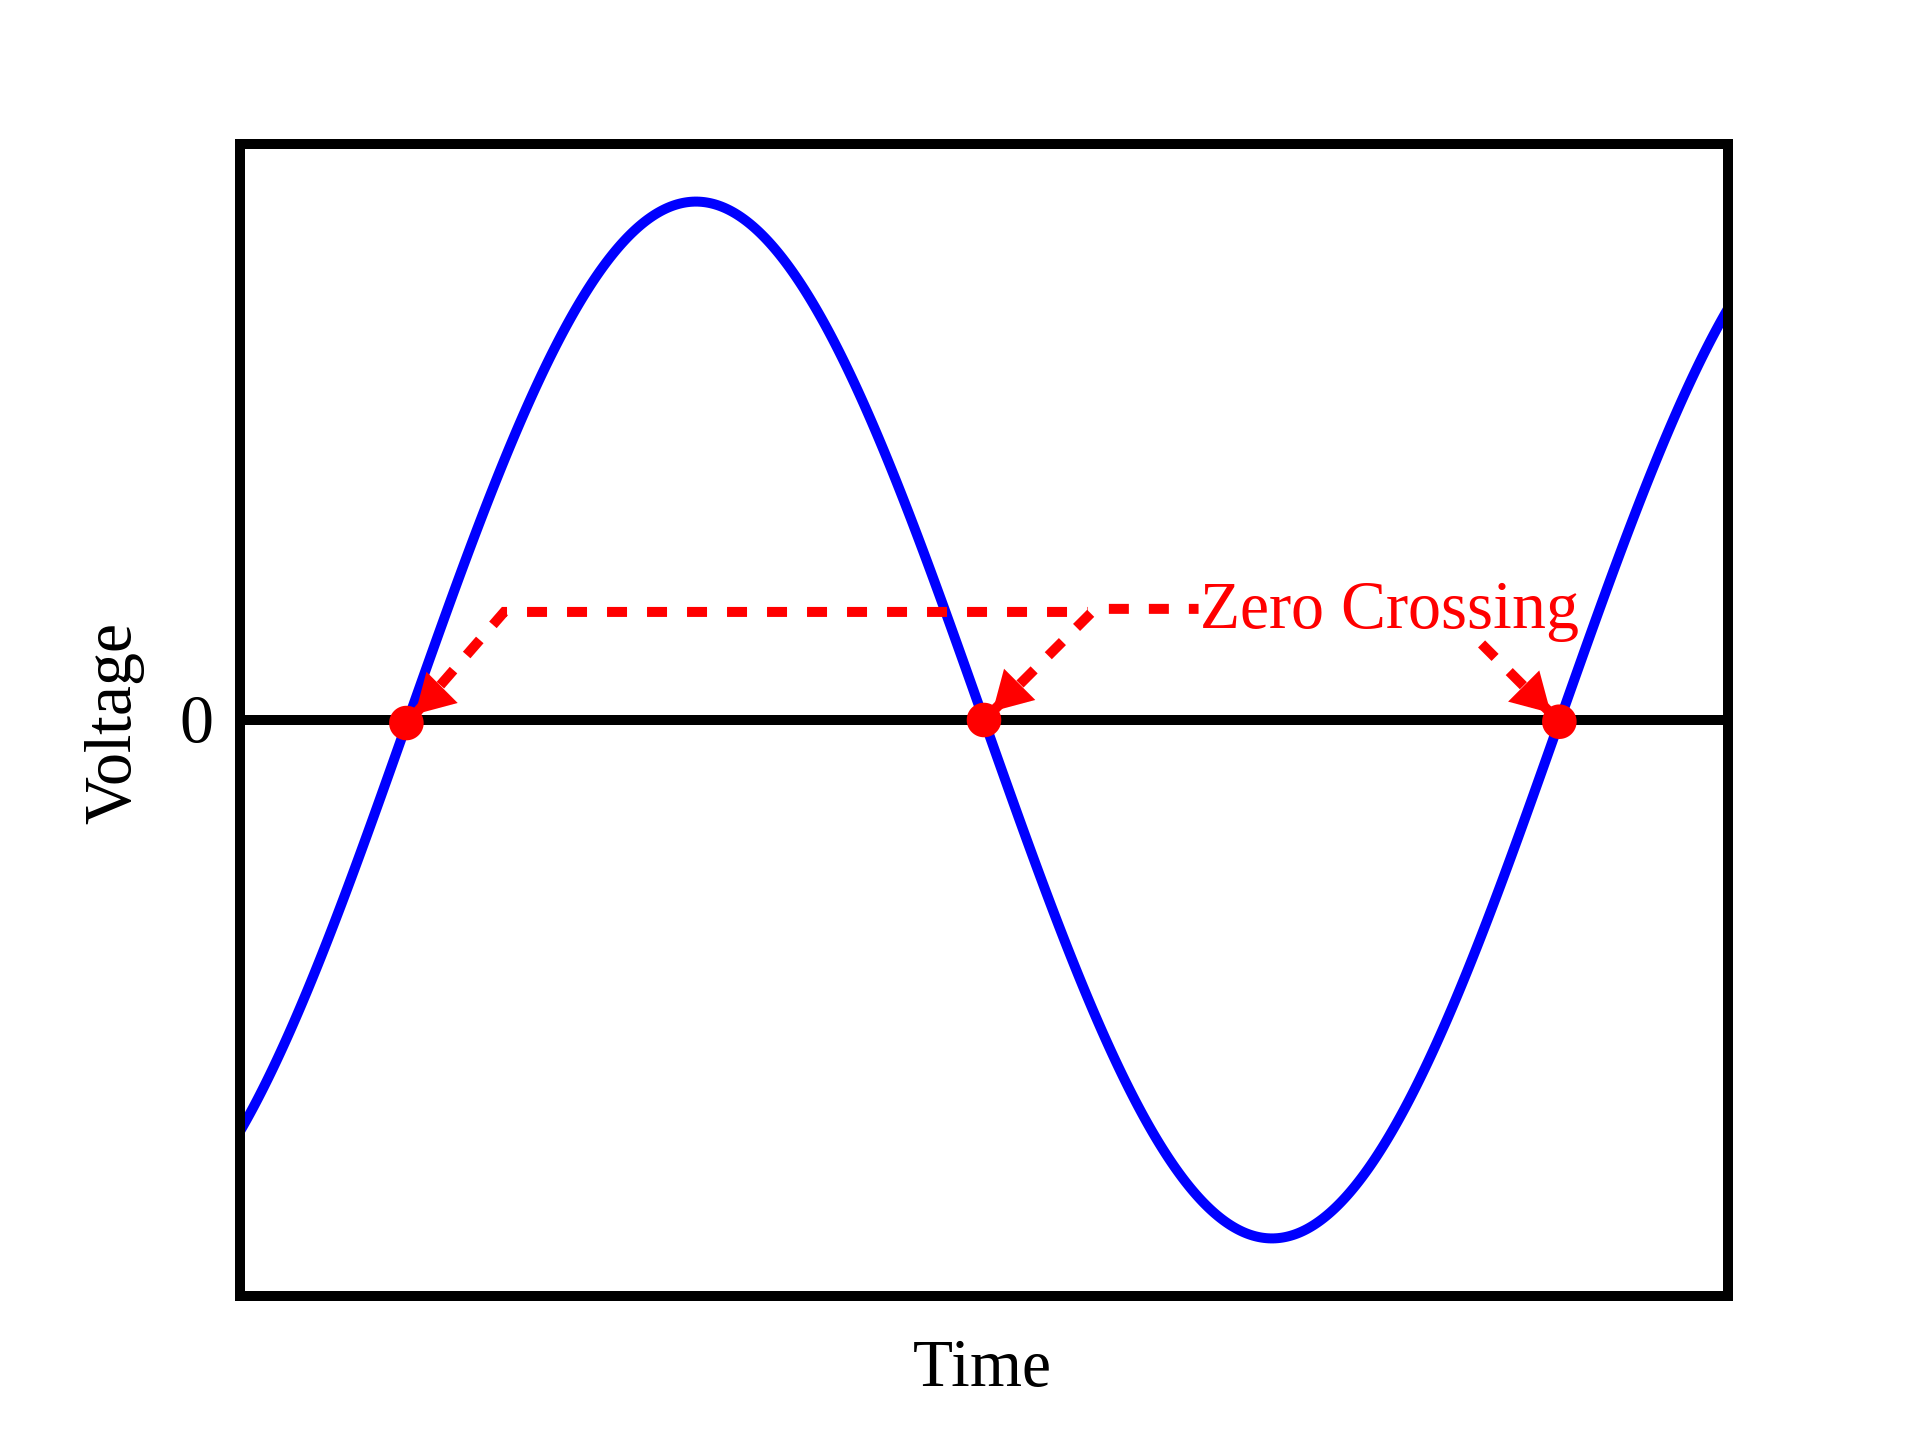

In [20]:
#Image Source - https://en.wikipedia.org/wiki/Zero_crossing#/media/File:Zero_crossing_2.svg
#Display image
path = "../images/external/Zero_crossing_2.svg.png"
Image(filename = path, width=600, height=500)

#### Zero Crossing Rate

The zero-crossing rate (ZCR) is the rate at which a signal transitions from positive to negative or from negative to positive.

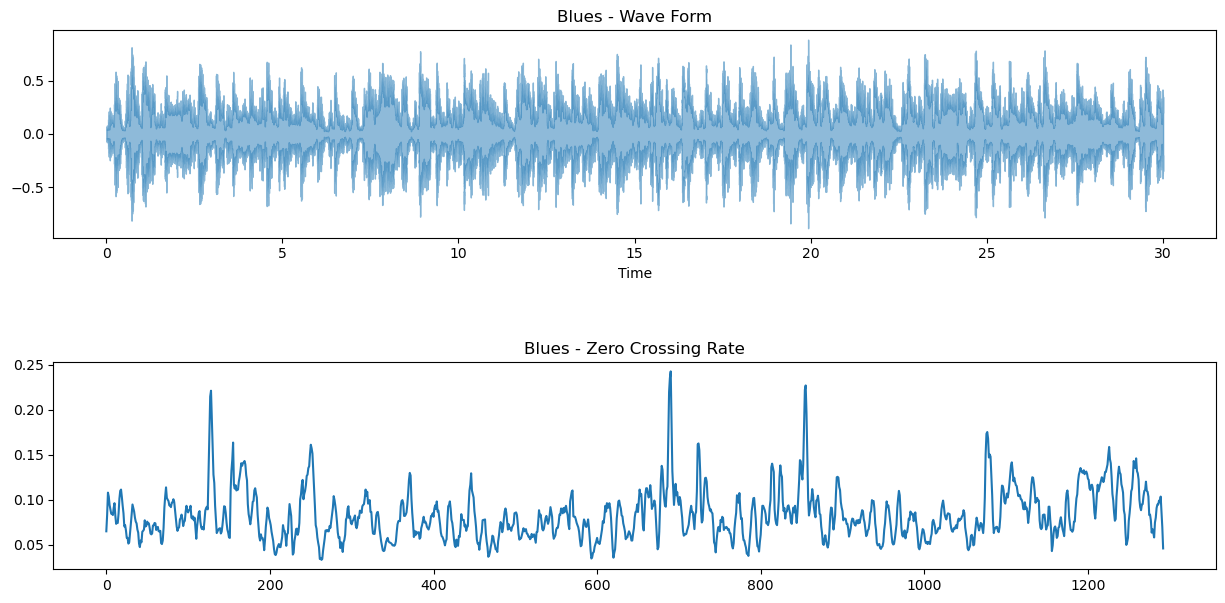

In [29]:
#plot waveform and zero crossing rate
fig, ax = plt.subplots(2,1, figsize=(15,7))
plt.subplots_adjust(hspace=0.6)
ax[0].set(title='Blues - Wave Form')
librosa.display.waveshow(blues,alpha = .5, ax = ax[0])
zcr = librosa.feature.zero_crossing_rate(y = blues)
ax[1].plot(zcr.T)
ax[1].set(title='Blues - Zero Crossing Rate');

Comparison of zero crossing rate to waveform.

## Frequency Domain Features
---

### Fourier Transform

The Fast Fourier Transform is an important method in audio and acoustics measurement. It converts a signal into individual spectral components and provides frequency information about the signal. Namely, a signal is sampled over a period of time and divided into its frequency components. These components are single sinusoidal oscillations at distinct frequencies each with their own amplitude and phase. <sup>13</sup> 

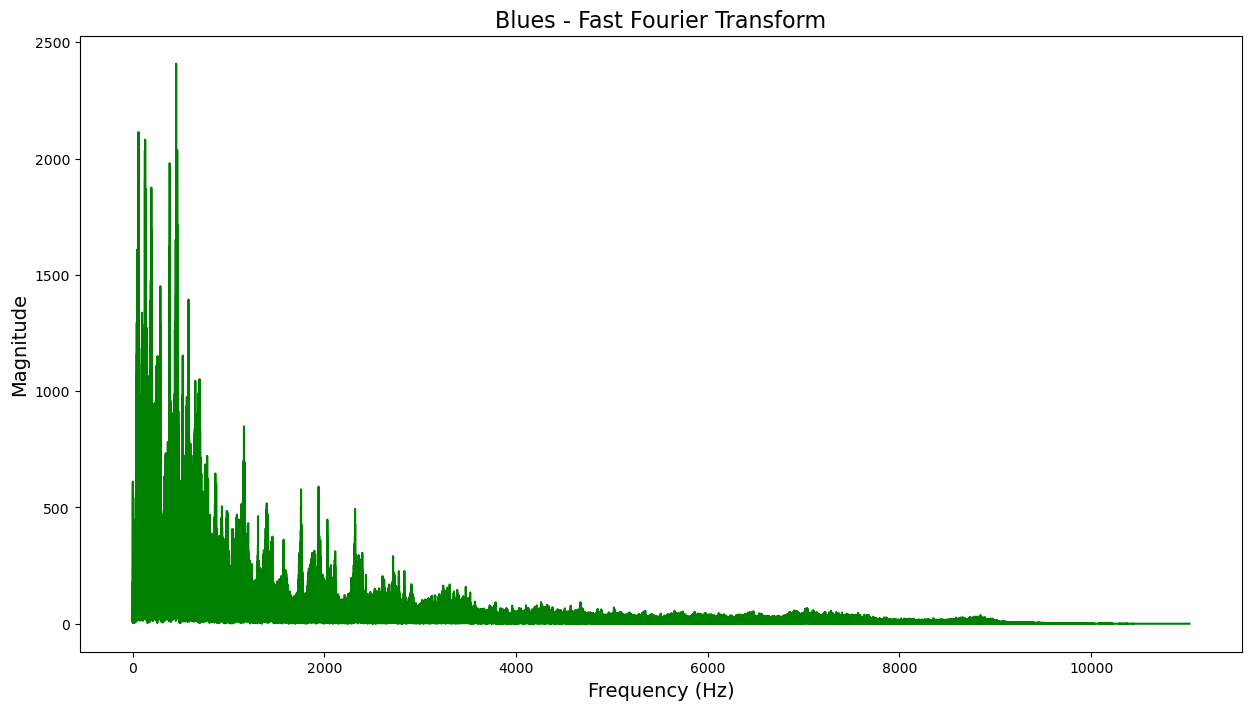

In [25]:
#Code Source

'''
https://github.com/musikalkemist/AudioSignalProcessingForML/blob/master/
10%20-%20Fourier%20Transform%3A%20The%20Intuition/Fourier%20Transform%20.ipynb
'''

# derive spectrum using FT
ft = sp.fft.fft(blues)

#contribution of each frequency to sound wave
magnitude = np.absolute(ft)
frequency = np.linspace(0, sr, len(magnitude)) 

# plot spectrum
plt.figure(figsize=(15, 8))
plt.plot(frequency[:len(frequency)//2], magnitude[:len(magnitude)//2], color = 'g') # magnitude spectrum
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.ylabel("Magnitude", fontsize = 14)
plt.title("Blues - Fast Fourier Transform", fontsize = 16)
plt.show()

### Short Term Fourier Transform

The short-time Fourier transform is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. This reveals the Fourier spectrum on each shorter segment. The changing spectra as a function of time can be plotted as a spectrogram.<sup>14</sup>

## Time-Frequency Domain Features
---

### Spectograms

A spectrogram is a visual way of representing the signal strength of a signal over time at various frequencies present in a particular waveform.<sup>15</sup>

The general steps:<sup>16</sup>
* Split the audio into overlapping chunks, or windows.
* Perform the Short Time Fourier Transformation on each window. 
* Take the resulting window and convert to decibels. 
* Arrange windows back into the length of the original song and display the output.

### Spectral Centroid

The spectral centroid (spectral mass) is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. It has a robust connection with the impression of brightness of a sound.<sup>17</sup>

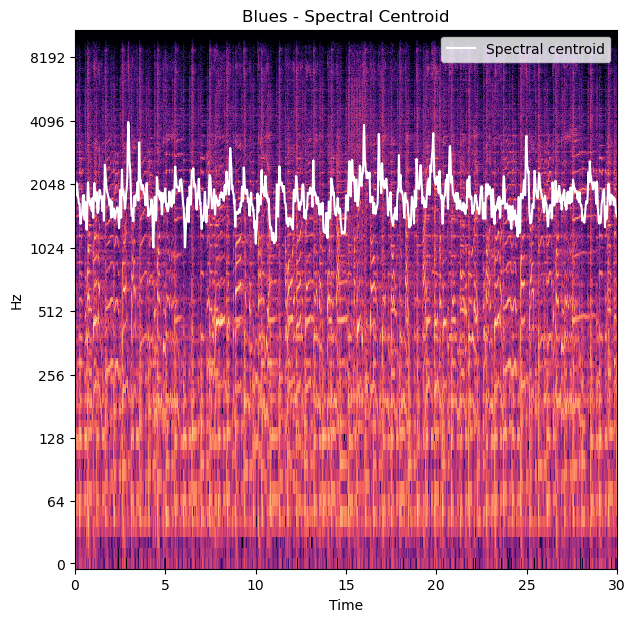

In [28]:
#Source - https://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html

plt.figure(figsize = (7,7))
centroid = librosa.feature.spectral_centroid(y=blues, sr=sr)
#time array that matches time axis of centroid
times = librosa.times_like(centroid)
#extract magnitude(S)
S, phase = librosa.magphase(librosa.stft(blues))
#convert to dB spectogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
#plot centroid
plt.plot(times, centroid.T, label='Spectral centroid', color='w')
plt.legend(loc='upper right')
plt.title('Blues - Spectral Centroid');

### Spectral Rolloff

It can be defined as the action of a specific type of filter which is designed to roll off the frequencies outside to a specific range. The spectral roll-off point is the fraction of bins in the power spectrum at which 85% of the power is at lower frequencies. This can be also be used for calculating the maximum and minimum by adjusting the roll percent.<sup>18</sup>

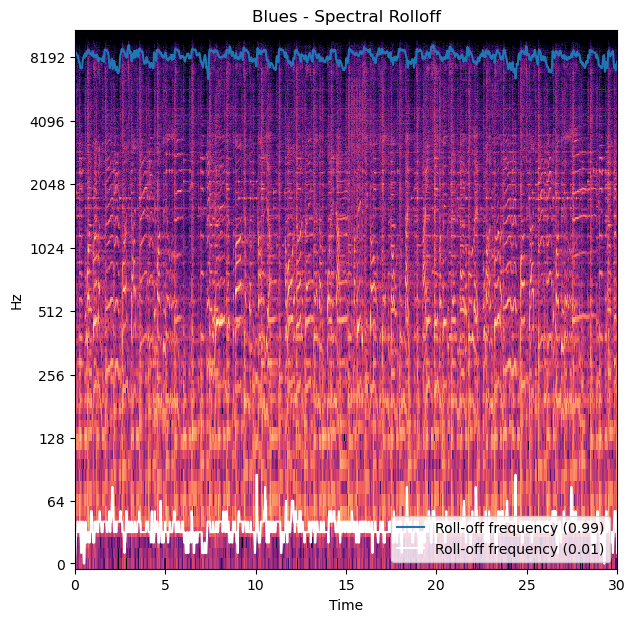

In [31]:
#Source - https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

plt.figure(figsize = (7,7))
rolloff = librosa.feature.spectral_rolloff(y=blues, sr=sr, roll_percent=0.99)
rolloff_min = librosa.feature.spectral_rolloff(y=blues, sr=sr, roll_percent=0.01)
S, phase = librosa.magphase(librosa.stft(blues))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
plt.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
plt.plot(librosa.times_like(rolloff), rolloff_min[0], color='w',
        label='Roll-off frequency (0.01)')
plt.legend(loc='lower right')
plt.title('Blues - Spectral Rolloff');

### Spectral Bandwidth

Bandwidth is the difference between the upper and lower frequencies in a continuous band of frequencies. The sum of the maximum deviation of the signal on both sides of the centroid can be considered as the bandwidth of the signal at that time frame.<sup>18</sup>

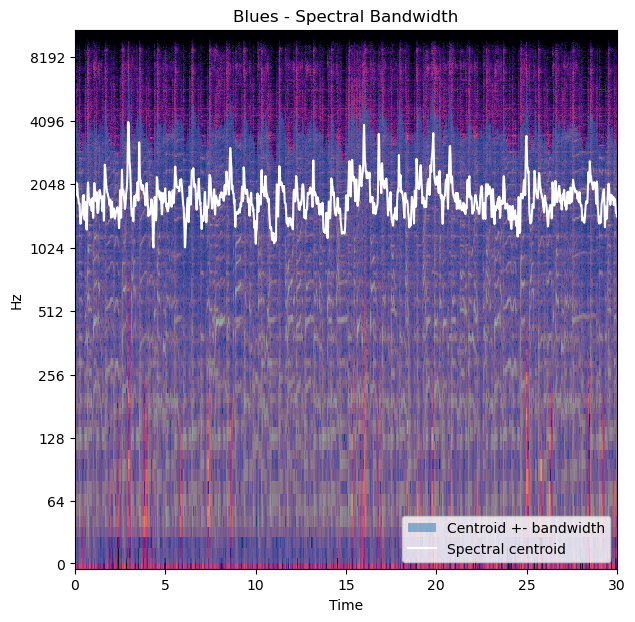

In [32]:
#Source
'''
https://librosa.org/doc/0.10.0/generated/
librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth
'''

plt.figure(figsize = (7,7))
bandwidth = librosa.feature.spectral_bandwidth(y=blues, sr=sr)
times = librosa.times_like(bandwidth)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
plt.fill_between(times, np.maximum(0, centroid[0] - bandwidth[0]),
                np.minimum(centroid[0] + bandwidth[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
plt.plot(times, centroid.T, label='Spectral centroid', color='w')
plt.legend(loc='lower right')
plt.title('Blues - Spectral Bandwidth');

### Spectral Contrast

The spectral contrast is the measure of the energy of frequency at each timestamp. Each frame of a spectrogram is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile to that of the bottom quantile.<sup>19</sup>

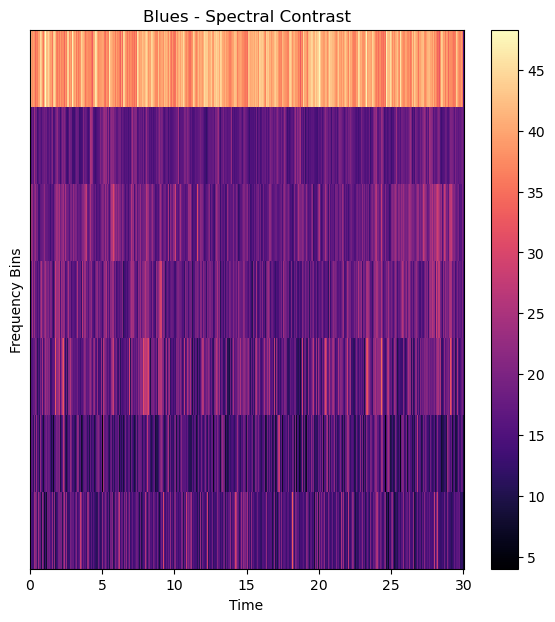

In [18]:
#Source
'''
https://librosa.org/doc/0.10.0/generated/
librosa.feature.spectral_contrast.html#librosa.feature.spectral_contrast
'''
plt.figure(figsize = (7,7))
S = np.abs(librosa.stft(blues))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
img = librosa.display.specshow(contrast, x_axis='time')
plt.colorbar(img)
plt.ylabel("Frequency Bins")
plt.title('Blues - Spectral Contrast');

### Spectral Flatness

Spectral flatness is typically measured in decibels, and provides a way to quantify how much a sound resembles a pure tone, as opposed to being noise-like. "The meaning of tonal in this context is in the sense of the amount of peaks or resonant structure in a power spectrum, as opposed to flat spectrum of a white noise."<sup>20</sup>

### Chromagram

Pitches are the property of any sound or signal which allows the ordering of files based on frequency-related scale. It is some kind of measurement of the quality of the sound which helps in judging the sound as higher, lower, and medium. An audio file can consist of 12 different pitch classes. The filter bank aims to project all the energy of the recorded sound into 12 bins representing the pitch classes.<sup>21</sup>

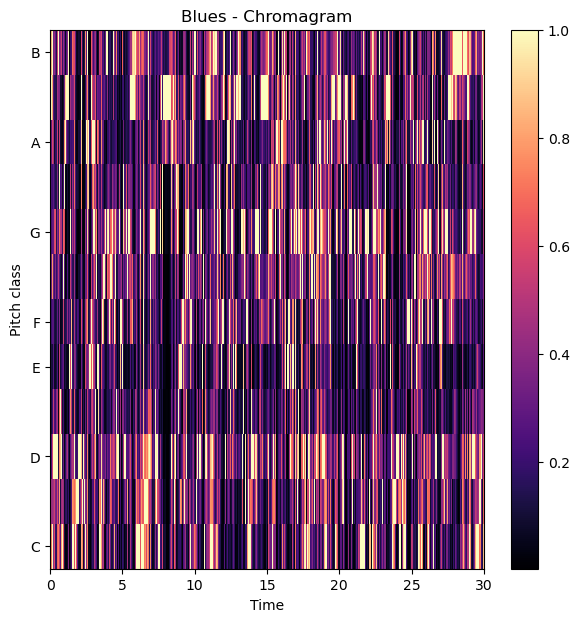

In [16]:
#Source - https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html

plt.figure(figsize = (7,7))
chroma = librosa.feature.chroma_stft(y=blues, sr=sr)
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.title('Blues - Chromagram')
fig.colorbar(img);

### Harmonic Percussive Separation

Librosa's HPSS function decomposes an audio time series into harmonic and percussive components.<sup>22</sup>

"A harmonic sound is what we perceive as pitched sound, what makes us hear melodies and chords. The prototype of a harmonic sound is the acoustic realization of a sinusoid, which corresponds to a horizontal line in a spectrogram representation. On the other hand, a percussive sound is what we perceive as a clash, a knock, a clap, or a click. The sound of a drum stroke or a transient that occurs in the attack phase of a musical tone are further typical examples. The prototype of a percussive sound is the acoustic realization of an impulse, which corresponds to a vertical line in a spectrogram representation."<sup>23</sup>

### Mel-frequency cepstral coefficients

The mel-frequency cepstral coefficients of an audio signal are a small set of features which describe the overall shape of the spectral envelope. <sup>24</sup>

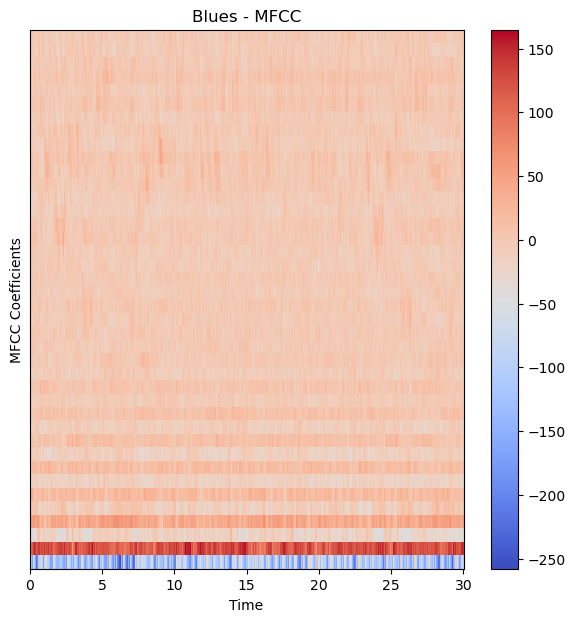

In [33]:
#Source - https://librosa.org/doc/main/generated/librosa.feature.mfcc.html

plt.figure(figsize = (7,7))
mfccs = librosa.feature.mfcc(y=blues, sr=sr, n_mfcc=40)
plt.title('Blues - MFCC')
plt.ylabel("MFCC Coefficients", loc = 'top')
img = librosa.display.specshow(mfccs, x_axis='time')
plt.ylabel("MFCC Coefficients")
fig.colorbar(img);

## Sources<a id='s'></a>
---

1. [Music Streaming Statistics in 2023](https://musicalpursuits.com/music-streaming/)
1. [Celebrating 100 million songs](https://www.apple.com/uk/newsroom/2022/10/celebrating-100-million-songs/)
1. [120,000 NEW TRACKS RELEASED ON STREAMING SERVICES EVERY DAY, REPORT FINDS](https://mixmag.net/read/120-000-new-tracks-are-released-on-streaming-services-every-day-report-finds-tech#:~:text=A%20new%20report%2C%20made%20by,work%20%2D%20according%20to%20the%20report.)
1. [Musical Genre Classification of Audio Signals](https://www.cs.cmu.edu/~gtzan/work/pubs/tsap02gtzan.pdf)
1. [How do sound waves work?](https://www.popsci.com/reviews/what-are-sound-waves/)
1. [Digital Audio Basics: Audio Sample Rate and Bit Depth](https://www.izotope.com/en/learn/digital-audio-basics-sample-rate-and-bit-depth.html)
1. [What is Tempo in Music: How Time Connects All Music](https://blog.landr.com/what-is-tempo/)
1. [LearningfromAudio](https://github.com/Osorio21/LearningfromAudio/blob/master/2%20-%20Time%20Domain%20Features.ipynb)
1. [Analysis of the Amplitude Envelopes of Various Music Genre Tracks](https://www.analyticsvidhya.com/blog/2022/05/analysis-of-the-amplitude-envelopes-of-various-music-genre-tracks/)
1. [RMS Level for Mastering: Achieving the Perfect Loudness](https://emastered.com/blog/rms-level-for-mastering#:~:text=What%20is%20RMS%3F,average%20of%20the%20audio%20signal.)
1. [Comparison of the RMS Energy and the Amplitude Envelope](https://www.analyticsvidhya.com/blog/2022/05/comparison-of-the-rms-energy-and-the-amplitude-envelope/)
1. [Analysis of Zero Crossing Rates of Different Music Genre Tracks](https://www.analyticsvidhya.com/blog/2022/01/analysis-of-zero-crossing-rates-of-different-music-genre-tracks/#:~:text=Zero%2DCrossing%20Rate%3A%20The%20zero,retrieval%20for%20classifying%20percussive%20sounds)
1. [Fast Fourier Transformation FFT - Basics](https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft)
1. [Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)
1. [What is a Spectrogram?](https://pnsn.org/spectrograms/what-is-a-spectrogram#:~:text=A%20spectrogram%20is%20a%20visual,present%20in%20a%20particular%20waveform.)
1. [Learning from Audio: Spectrograms](https://towardsdatascience.com/learning-from-audio-spectrograms-37df29dba98c)
1. [Spectral Centroid](https://en.wikipedia.org/wiki/Spectral_centroid)
1. [A Tutorial on Spectral Feature Extraction for Audio Analytics](https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/)
1. [Spectral Contrast](https://librosa.org/doc/0.10.0/generated/librosa.feature.spectral_contrast.html#librosa.feature.spectral_contrast)
1. [Spectral Flatness](https://en.wikipedia.org/wiki/Spectral_flatness)
1. [Learning from Audio: Pitch and Chromagrams](https://towardsdatascience.com/learning-from-audio-pitch-and-chromagrams-5158028a505)
1. [Librosa HPSS](https://librosa.org/doc/0.10.0/generated/librosa.effects.hpss.html#librosa.effects.hpss)
1. [Harmonic–Percussive Separation (HPS)](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C8/C8S1_HPS.html)
1. [Intuitive understanding of MFCCs](https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779)